In [36]:
!pip install py7zr

In [37]:
import pandas as pd
import numpy as np
import py7zr
import os
import matplotlib.pyplot as plt
import seaborn as sns

https://www.kaggle.com/code/suchadapleasong/iceberg


**`EXPLORATORY DATA ANALYSIS`**

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# from google.colab import files
# uploaded = files.upload()

In [40]:
import zipfile
import os

zipfile_path = '/content/drive/MyDrive/statoil-iceberg-classifier-challenge.zip'
#zipfile_path = '/kaggle/statoil-iceberg-classifier-challenge.zip'

with zipfile.ZipFile(zipfile_path, "r") as z:
    z.extractall("/kaggle/working")   # extract to working directory

with zipfile.ZipFile(zipfile_path, "r") as z1:
    z1.extractall("/kaggle/working")

# check what files are extracted
print(os.listdir("/kaggle/working"))

['train.json.7z', 'sample_submission.csv.7z', 'test.json.7z']


In [41]:
with py7zr.SevenZipFile('/kaggle/working/train.json.7z', mode='r') as z:
    z.extractall()
    #print(z.getnames())

with py7zr.SevenZipFile('/kaggle/working/test.json.7z', mode='r') as z1:
    z1.extractall()
    #print(z1.getnames())

The pixel intensity values are often converted to a physical quantity called the backscattering coefficient or normalised radar cross-section measured in decibel (dB) units with values ranging from +5 dB for very bright objects to -40 dB for very dark surfaces.

In [42]:
# data/processed/test.json
# data/processed/train.json

train = pd.read_json('data/processed/train.json')
test = pd.read_json('data/processed/test.json')
# train.head(5)
test.head(5)

,id,band_1,band_2,inc_angle
0,5941774d,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",34.966400
1,4023181e,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",32.615072
2,b20200e4,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",37.505433
3,e7f018bb,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",34.473900
4,4371c8c3,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",43.918874


In [43]:
# check if there are null values in any column
inc_angle_na = train['inc_angle'].isna().sum()
is_iceberg_na = train['is_iceberg'].isna().sum()
band_1_na = train['band_1'].isna().sum()
band_2_na = train['band_2'].isna().sum()

print(f'inc_angle_na: {inc_angle_na}')
print(f'is_iceberg_na: {is_iceberg_na}')
print(f'inc_angle_na: {band_1_na}')
print(f'is_iceberg_na: {band_2_na}')

inc_angle_na: 0
is_iceberg_na: 0
inc_angle_na: 0
is_iceberg_na: 0


In [44]:
# drop id columns in test and train, not needed
# train.drop('id', axis=1, inplace = True)
# test.drop('id', axis=1, inplace = True)


In [45]:
total_num_icebergs = train['is_iceberg'] == 1
print("is iceberg:" , total_num_icebergs.sum())

total_num_ships = train['is_iceberg'] == 0
print("is ship:   " , total_num_ships.sum())

is iceberg: 753
is ship:    851


In [46]:
# each array in band_1 and band_2 has 5625 values.
band_1 = np.array(train['band_1'].head())
band_2 = np.array(train['band_2'].head())

print ("band 1 array size:", len(band_1[0]))
print ("band 2 array size:", len(band_2[0]))

# get singular values for band1 mean, median, standard deviation (can't do unless I loop through every 5626 length array and get the standard deviation of each row)
band1_mean = np.mean(np.mean(band_1))
band1_median = np.median(np.median(band_1))
#band1_std = np.std(band_1)

print("\nband_1 mean:", band1_mean)
print("band_1 median:", band1_median)
#print(band1_std)

# get singular values for band2 mean, median, standard deviation
band2_mean = np.mean(np.mean(band_2))
band2_median = np.median(np.median(band_2))
#band2_std = np.std(band_2)

print("\nband_2 mean:", band2_mean)
print("band_2 median:", band2_median)
#print(band2_std)

band 1 array size: 5625
band 2 array size: 5625

band_1 mean: -4.520883768967111
band_1 median: -22.935019

band_2 mean: -5.4121873680284445
band_2 median: -25.466921


https://www.kaggle.com/code/suchadapleasong/iceberg


**`RESCALE IMAGES + ADD THIRD BAND`**

In [47]:
def get_scaled_imgs(df):
    imgs = []

    for i, row in df.iterrows():

        # make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))
    return np.array(imgs)

data = get_scaled_imgs(train) # use this on the train set
target = np.array(train['is_iceberg']) # used to print out just the labels from is_iceberg

print(data.shape)
print(target.shape)

(1604, 75, 75, 3)
(1604,)


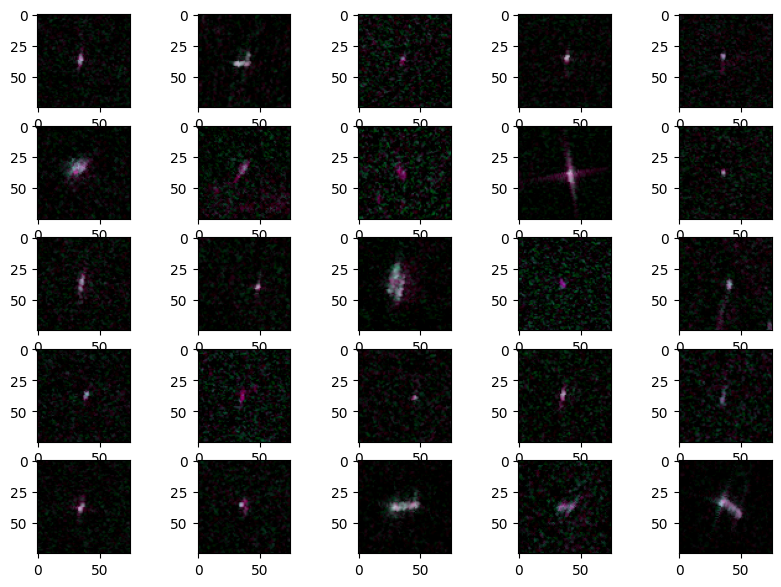

In [48]:
# view images
fig = plt.figure(figsize=(10, 7))
rows = 5
columns = 5

for i in range(25):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(data[i])

In [49]:
print(target[:5]) # label for the first 5 images

[0 0 1 0 0]


**`RANDOM FOREST REGRESSOR`**

In [50]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
train = train.drop(columns=["id"])

In [52]:
test = test.drop(columns=["id"])

In [53]:
train_batch = train.iloc[:30] # only use first 30 images

# get mean from each band (can change the computation `of the band values)
train_batch['band_1_mean'] = train_batch['band_1'].apply(lambda x: np.mean(x))
train_batch['band_2_mean'] = train_batch['band_2'].apply(lambda x: np.mean(x))

train_batch.drop(columns=['band_1', 'band_2'], inplace=True)

/tmp/ipython-input-3824433676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_batch['band_1_mean'] = train_batch['band_1'].apply(lambda x: np.mean(x))
/tmp/ipython-input-3824433676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_batch['band_2_mean'] = train_batch['band_2'].apply(lambda x: np.mean(x))
/tmp/ipython-input-3824433676.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [54]:
y = train_batch['is_iceberg']
X = train_batch.drop(columns = 'is_iceberg', axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=1234)

In [55]:
# i will test the random forest regressor on a smaller sample size
rf_model = RandomForestRegressor(max_depth=8, n_estimators=80)
rf_model.fit(x_train, y_train)
y_rf_pred = rf_model.predict(x_test)
rf_rmse = mean_squared_error(y_test, y_rf_pred) # Calculate RMSE by taking the square root
rf_r2 = r2_score(y_test, y_rf_pred)

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))

[RF] Root Mean Squared Error: 0.4627272727272727
[RF] R2: -0.999642857142857


In [56]:
cv_scores = cross_val_score(rf_model, X, y, scoring='r2', cv=5)
print("Cross-validated R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

acc_std = np.std(cv_scores)
print('Standard deviation for 5 iterations:', acc_std)

Cross-validated R² scores: [ 0.33074219  0.08558594 -1.10984375 -0.49981771 -0.43916667]
Mean CV R²: -0.3264999999999999
Standard deviation for 5 iterations: 0.5016258265637441


**`ConvNeXT - Getting Embeddings from Test Data`**

In [57]:
from PIL import Image
from transformers import AutoImageProcessor, ConvNextForImageClassification
import torch

In [58]:
# load and preprocess data
processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [59]:
batch = test.iloc[:50] # test on first 50 images - doesn't work for me if I run all images

In [60]:
# normalize band between 0 and 1
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return (band - band_min) / (band_max - band_min + 1e-6)

# has to have 3 bands, so reshape band_1 and band_2, average band_1 and band_2 for band_3
def scale_test_imgs(row):
    band_1 = np.array(row.band_1).reshape(75, 75)
    band_2 = np.array(row.band_2).reshape(75, 75)
    band_3 = (band_1 + band_2) / 2

    # normalize bands to [0,1]
    band_1 = normalize_band(band_1)
    band_2 = normalize_band(band_2)
    band_3 = normalize_band(band_3)

    # stack
    img = np.stack([band_1, band_2, band_3], axis=-1)  # shape: (75,75,3)
    return (img * 255).astype(np.uint8)

In [61]:
# convert to PIL
test_images_pil = [Image.fromarray(scale_test_imgs(row)) for _, row in batch.iterrows()]
processor = AutoImageProcessor.from_pretrained("facebook/convnext-base-224")

# feed images to HuggingFace processor
inputs = processor(images=test_images_pil, return_tensors="pt")

In [62]:
# load ConvNeXT model
model = ConvNextForImageClassification.from_pretrained(
    "facebook/convnext-base-224",
    num_labels=2, # for binary classification
    ignore_mismatched_sizes=True
)
model.eval()

# move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# will give a warning

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
# make predictions and get predicted labels
with torch.no_grad():
    outputs = model(**inputs)
    predicted_labels = outputs.logits.argmax(dim=1).cpu().numpy()  # 0 or 1

In [64]:
# print predicted labels for the first 50 images
predicted_labels

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0])

In [65]:
# save to pkl file
import pickle

pkl_filename = "ConvNeXT_test_images.pkl"

# save list of images
with open(pkl_filename, "wb") as f:
    pickle.dump(test_images_pil, f)

print(f"Saved {len(test_images_pil)} images to {pkl_filename}")

Saved 50 images to ConvNeXT_test_images.pkl


**`Clustering`**

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [67]:
band1 = np.stack(batch['band_1'].apply(np.array))
band2 = np.stack(batch['band_2'].apply(np.array))

band1_dB = 10 * np.log10(np.clip(band1, 1e-6, None))
band2_dB = 10 * np.log10(np.clip(band2, 1e-6, None))

features = np.stack([band1_dB.flatten(), band2_dB.flatten()], axis=-1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)